# Anders' analysis notebook: Sharing data with amie

Anders needs to combine Fritz's and Francesca's data and analyze it. ```garden.tips()``` will grab the latest leaves from a tree, so even if new data gets added, Anders just needs to re-run the script and it will automatically use the new data. 
He writes two functions that integrate with amie:

```load_and_concat``` will load the latest datafiles from the trees and concatenate them into a single pandas dataframe. It will also add references to the leaves where the data came from, so he does not have to re-upload the data.

```analyse``` will perform basic analysis on a dataset, like histograms and correlations and upload them into a new leaf

In [88]:
import amieci
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

def load_and_concat(garden, tree_ids, parent=None, save=True, leaf=None):
    
    tips = garden.tips()
    
    if not leaf:
        leaf = garden.ct.new_leaf(parent=parent)
    
    #Load the latest data from Fritz and Francesca
    dataframes = []
    for tree in tree_ids:
        for data_leaf in tips[tree]:
            # I take the files which are actual datafiles, because they may also contain images.
            # If there is no datafile, just pass 
            try:
                datafile = garden.leaves[data_leaf].download_data(filename='.csv')[0]
                dataframes.append(pd.read_csv(datafile, sep=';',index_col=0))
                leaf.add_reference(garden, data_leaf)
            except:
                pass 
            

    #Concatenate the data
    data = pd.concat(dataframes, axis=1)
    

    #Add the new dataset
    leaf.add_data('winedata.csv', bytes(data.to_csv(), 'utf-8'), caption='concatinated wine')
    
    
    if save:
        leaf.save()
        
    return leaf, data

def analyse(garden, data, parent=None, save=True, leaf=None):
    try:
        leaf = garden.ct.new_leaf(parent=parent)
    except:
        pass
    
    fig = plt.figure()
    plt.hist(data['quality']);
    plt.xlabel('quality'); plt.ylabel('Number of wines'); 
    plt.title('Quality Distribution');
    plt.show()
    leaf.add_plot('quality_distribution.png', fig, caption='Quality Distribution')

    fig, axs = plt.subplots(nrows=4,ncols=3)
    fig.set_figwidth(15)
    fig.set_figheight(14)
    for idx, col in enumerate(data):
        axs.flatten()[idx].hist(data[col],bins=10)
        axs.flatten()[idx].set_xlabel(col)
        axs.flatten()[idx].set_ylabel('Number of wines')
    plt.show()
    leaf.add_plot('feature_distributions.png', fig, caption='feature distributions')

    mean_quality = data.quality.mean(axis=0)
    leaf.kvs.add("quality_mean", mean_quality)
    
    max_quality = data.quality.max(axis=0)
    leaf.kvs.add("quality_max", max_quality)
    
    min_quality = data.quality.min(axis=0)
    leaf.kvs.add("quality_min", min_quality)

    correlations_data = data.corr()['quality'].sort_values(ascending=False)
    correlations = correlations_data.head(100).round(2).abs().drop(['quality']).to_dict()
    for key, val in correlations.items():
        del correlations[key]
        newkey = key.replace(" ", "_") + '_corr'
        correlations[newkey] = val
    leaf.kvs.load_from_dict(correlations)
    

    fig = plt.figure()
    plt.plot(data['alcohol'], data['quality'], 'ro')
    plt.xlabel('alcohol')
    plt.ylabel('quality')
    plt.show()
    leaf.add_plot('quality_alc.png', fig,'quality to alcohol correlation')

    fig = plt.figure()
    plt.plot(data['volatile acidity'], data['quality'], 'ro')
    plt.xlabel('volotile acidity')
    plt.ylabel('quality')
    plt.show()
    leaf.add_plot('quality_vol.png', fig,'quality to volatile acidity correlation')


    fig = plt.figure()
    plt.plot(data['volatile acidity'], data['alcohol'], 'ro')
    plt.xlabel('volatile acidity')
    plt.ylabel('alcohol')
    plt.show()
    leaf.add_plot('alc_vol.png', fig,'alcohol to volatile acidity correlation')
    if save:
        leaf.save()
    return leaf

# Log in on amie.ai and go to "www.amie.ai/#/user to get your API key
garden = amieci.Garden(key="anders_key")
garden.load()


In [76]:
garden.new_tree()
garden.ct.set_title("Wine data science")
garden.ct.set_description("Modeling wine quality based on features from chemical tests")
garden.ct.save()

In [77]:
plan_leaf = garden.ct.new_leaf()
plan_leaf.set_title("The plan")
plan_leaf.set_description("""1. Load the data from Fritz and Francesca \n
                        2. Do some descriptive statistics
                        3. Do ML to find the Überwein""")
plan_leaf.save()

# Load the data 
Anders just needs to get the IDs of Fritz's and Francesca's trees. He can get them from them or just look them up in the app.

In [89]:
tree_ids = ['0a5fd360-038f-4cd8-9294-069dea4fad66', 'f6dc0e23-81dd-4a87-84d8-bfb158025a79']
leaf, data = load_and_concat(garden, tree_ids, save=False)
leaf.insert_description("""Loading and concatenating the data I got from Fritz and Francesca. I cast them to a pandas dataframe.
                            """)
leaf.set_title("Loading the data")
leaf.save()

# Look at the data

In [90]:
data.head()

,alcohol,fixed acidity,volatile acidity,citric acid,pH,free sulfur dioxide,total sulfur dioxide,sulphates,residual sugar,chlorides,density,quality
0,9.4,7.4,0.70,0.00,3.51,0.191770,0.705791,0.423999,1.9,0.076,0.9978,5
1,9.8,7.8,0.88,0.00,3.20,0.644463,0.300566,0.461294,2.6,0.098,0.9968,5
2,9.8,7.8,0.76,0.04,3.26,0.899217,0.545313,0.350663,2.3,0.092,0.9970,5
3,9.8,11.2,0.28,0.56,3.16,0.014106,0.451639,0.300848,1.9,0.075,0.9980,6
4,9.4,7.4,0.70,0.00,3.51,0.746436,0.641274,0.389566,1.9,0.076,0.9978,5


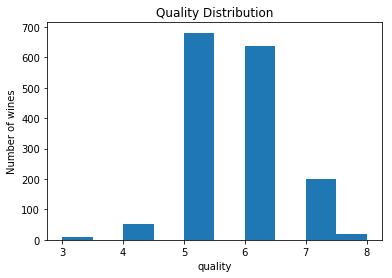

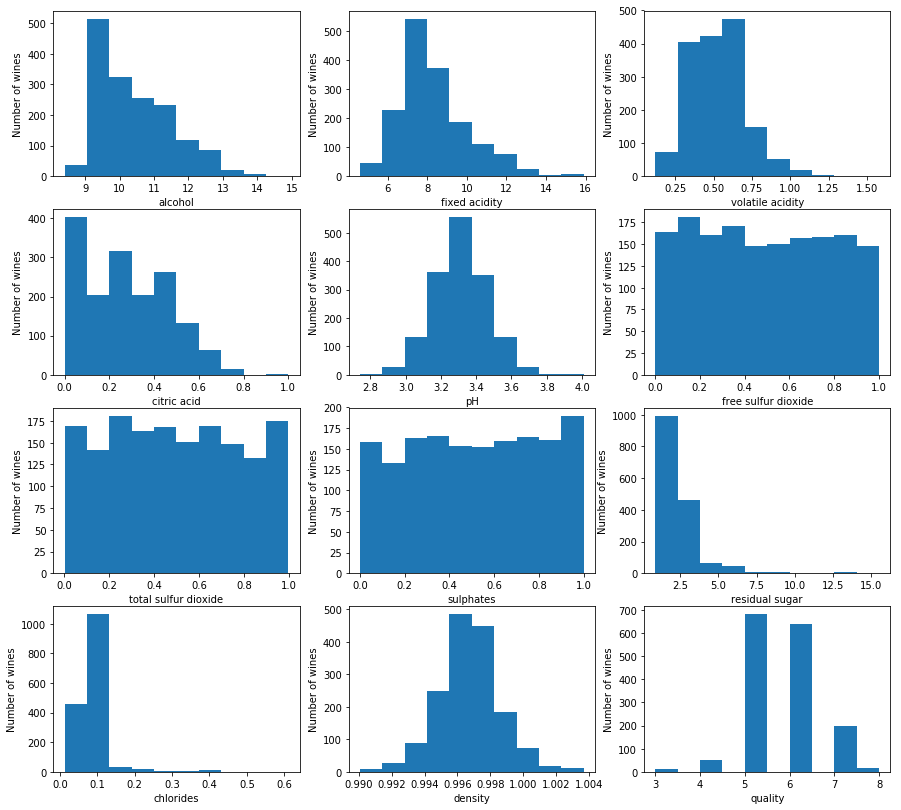

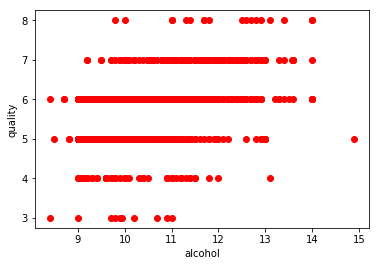

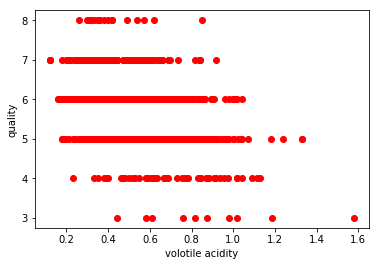

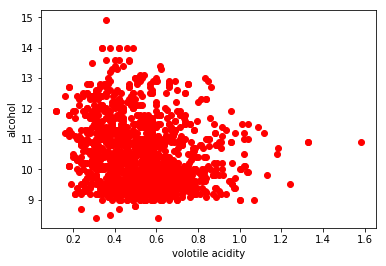

In [91]:
leaf = analyse(garden, data, parent=leaf, save=False)

In [92]:
leaf.set_description("""To get a quick overview, I plot histograms of the quality ($Img 1$) all features ($Img 2$) and the pearson correlations between them and the quality.
                        There is something strange going on with the sulfur measurements. 
                        #total_sulfur_dioxide_corr 0# #residual_sugar_corr 0# #free_sulfur_dioxide_corr 0.02# and #sulfares_corr 0.03# are all the least correlated parameters. 
                        Have to get back to Fritz about that. It does not look like real data. \n
                        """)
leaf.save()

Apparently there has been some mistake. Fritz can understand Anders' reasoning by looking at the leaf he points him to and he re-does the measurement.

# Reload data 
After the mistake has been found, Anders just needs to re-run both commands to load the new data and analyze it.

In [93]:
leaf, data = load_and_concat(garden, tree_ids, parent=plan_leaf, save=False)
leaf.set_description("""Re-loading and concatenating the data I got from Fritz and Francesca. I cast them to a pandas data frame. Fritz has re-done the sulfur measurements.""")
leaf.save()

# Look at the data - again

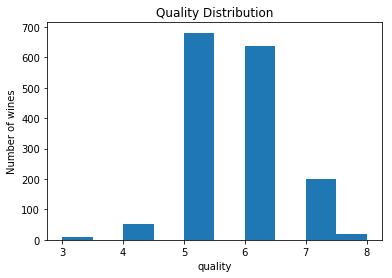

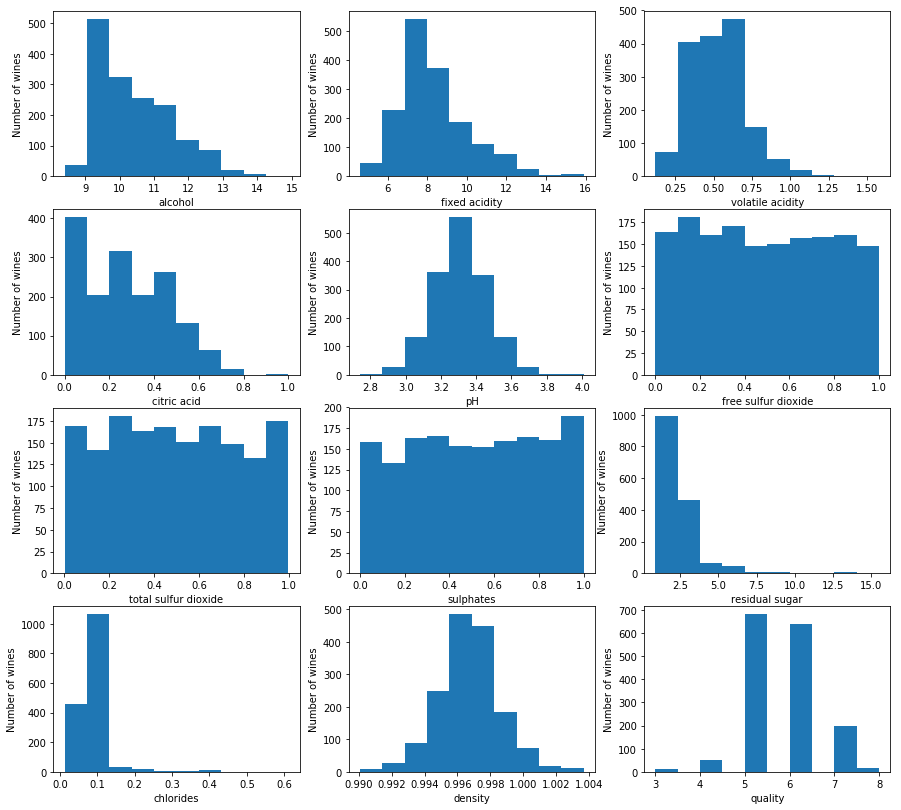

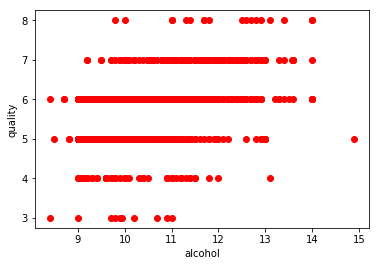

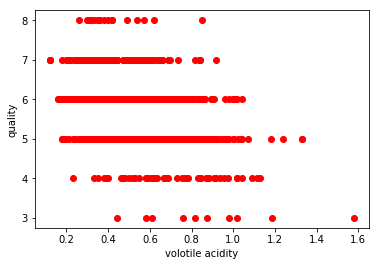

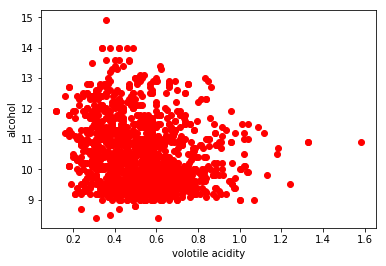

In [94]:
leaf = analyse(garden, data, parent=leaf, save=False)

In [96]:
leaf.set_description("""To get a quick overview, I plot histograms of all features again.
                        Now the sulfur looks like real data. \n
                        """)
leaf.save()